# TKO_7092 Evaluation of Machine Learning Methods 2023

## Exercise 4

Complete the tasks given to you in the letter below. There are cells at the end of this notebook to which you are expected to write your code. Insert markdown cells as needed to describe your solution. Remember to follow all the general exercise guidelines stated in Moodle.

The deadline of this exercise is **Wednesday 22 February 2023 at 23:59**. Please contact Juho Heimonen (juaheim@utu.fi) if you have any questions about this exercise.


---

Student name: Guanghang Chen

Student number: 521084

Student email: guchen@utu.fi

---


Dear Data Scientist,

I have a task for you that concerns drug molecules and their targets. I have spent a lot of time in a laboratory to measure **how strongly potential drug molecules bind to putative target molecules.** I do not have enough resources to measure all possible drug-target pairs, so I would like to first predict their affinities and then measure only the most promising ones. I have already managed to create a model which I believe is good for this purpose. Its details are below.

- algorithm: K-nearest neighbours regressor
- parameters: K=20
- training data: all the pairs for which I have measured the affinity

The data I used to create the model is available in the files `input.data`, `output.data` and `pairs.data` for you to use. The first file contains the features of the pairs, whereas the second contains their affinities. The third file contains the identifiers of the drug and target molecules of which the pairs are composed. The files are paired, i.e. the i<sup>*th*</sup> row in each file is about the same pair.

`input.data` - features of pair <br>
`output.data` -  affintities of pair <br>
`pairs.data` - id of drug and target molecules pair <br>

I am not able to evaluate how well the model will perform if I use it to predict the affinities of new drug-target pairs. I need you to evaluate the model for me. There are three distinct situations in which I want to use this model in the future.

1. Because I have only measured the affinities for some of the possible pairs of the currently known drugs and targets, I want to use the model to predict the affinities for the remaining pairs. (`Predict affinities for the remaining pairs of known drugs and targets`)
2. I am confident that I will discover new potential drug molecules in the future, so I will want to use the model to predict their affinities to the currently known targets. (`Predict affinities of new potential drug molecules to known targets(type B, remove 1st-pair member)`)
3. Because new putative target molecules, too, will likely be identified in the future, I will also want to use the model to predict the affinities between the drug molecules I will discover and the target molecules somebody else will discover in the future. (`Predict affinities between new drug molecules and new target molecules, Type D, remove 1st, 2nd pair member`)

Please evaluate the generalisation performance of the model in these three situations. I need to get evaluation results from **leave-one-out cross-validation with C-index**. Also, because I'm worried that unreliable evaluation results will mislead me to waste precious resources, please explain why I can trust your results.


Yours sincerely, \
Bio Scientist

---

#### Import libraries

In [1]:
# Import the libraries you need.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns 

from sklearn.neighbors import KNeighborsRegressor
from lifelines.utils import concordance_index


#### Load datasets

In [2]:
# Read the data files (input.data, output.data, pairs.data).
features_df = pd.read_csv('input.data', sep=' ', header=None)
affinities_df = pd.read_csv('output.data', sep=' ', header=None, names=['affinity'])
pairs_df = pd.read_csv('pairs.data', sep=' ', header=None, names=['drug', 'target'])

data_df = pd.concat([features_df, affinities_df, pairs_df], axis=1)

data_df

,0,1,2,3,4,5,6,7,8,9,...,2493,2494,2495,2496,2497,2498,2499,affinity,drug,target
0,6.53771,7.04273,7.30593,7.04480,7.32600,7.15379,6.46464,7.33308,6.25152,7.29930,...,8.28991,8.27096,7.65185,8.13150,8.13992,7.36155,7.98930,10000.0,D23,T194
1,4.26878,4.05945,4.40541,4.73575,4.25489,4.61444,4.72028,4.71408,5.43478,4.75449,...,6.61113,6.97087,7.23425,6.57285,8.38097,6.80756,7.12181,10000.0,D9,T270
2,7.24802,5.96468,7.02855,6.52784,7.38776,7.43236,6.06098,7.68345,6.91821,8.41192,...,7.20765,7.60826,6.05150,7.23766,6.75104,5.72958,6.73456,10000.0,D3,T47
3,3.00092,3.33087,3.57794,3.31246,3.43355,3.35872,3.32773,3.29331,5.89109,3.39740,...,3.01052,2.79974,2.93089,2.81599,2.74684,2.93389,2.76753,10000.0,D49,T222
4,4.34096,3.79832,5.67286,4.20168,4.74336,4.97859,3.56746,4.55088,4.30942,3.99160,...,2.87061,3.12170,2.92398,3.26003,2.70133,2.87879,2.64117,270.0,D37,T28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,8.57018,9.04255,9.63228,8.77320,9.78987,9.97577,9.68539,9.17266,8.66047,9.56224,...,5.55991,5.27942,5.06684,5.48311,5.35253,5.07481,5.57504,10000.0,D33,T426
1496,7.36589,8.12633,8.04439,8.31312,8.11686,7.33734,8.11067,8.19454,12.42720,8.77493,...,4.69769,4.69417,5.12240,4.82360,5.03664,4.87108,4.61108,10000.0,D55,T267
1497,6.11318,9.20208,6.96815,8.02065,7.02480,6.78667,7.61725,6.58085,6.47229,6.60451,...,7.02489,7.53969,8.30141,6.94445,6.71488,8.12290,7.16530,10000.0,D39,T372
1498,6.45690,7.89646,6.76667,7.62162,6.61818,6.30901,7.58741,6.70339,9.15385,8.68000,...,5.83832,6.15672,6.44876,5.87900,6.79348,12.50000,6.73077,10000.0,D34,T300


Number of drugs: 60
['D23' 'D9' 'D3' 'D49' 'D37' 'D17' 'D54' 'D59' 'D2' 'D52' 'D40' 'D25'
 'D53' 'D26' 'D29' 'D19' 'D43' 'D39' 'D33' 'D18' 'D1' 'D48' 'D20' 'D38'
 'D61' 'D44' 'D65' 'D13' 'D47' 'D35' 'D64' 'D66' 'D4' 'D27' 'D22' 'D51'
 'D56' 'D46' 'D67' 'D16' 'D6' 'D21' 'D34' 'D14' 'D41' 'D32' 'D50' 'D24'
 'D58' 'D36' 'D11' 'D63' 'D5' 'D28' 'D15' 'D57' 'D55' 'D10' 'D45' 'D8']
Number of targets: 60
['T194' 'T270' 'T47' 'T222' 'T28' 'T13' 'T152' 'T348' 'T78' 'T334' 'T254'
 'T21' 'T40' 'T421' 'T156' 'T388' 'T164' 'T118' 'T146' 'T357' 'T326'
 'T324' 'T313' 'T331' 'T308' 'T183' 'T237' 'T365' 'T283' 'T359' 'T20'
 'T62' 'T386' 'T178' 'T66' 'T264' 'T413' 'T372' 'T296' 'T306' 'T374'
 'T267' 'T232' 'T177' 'T256' 'T349' 'T299' 'T200' 'T242' 'T300' 'T426'
 'T408' 'T29' 'T437' 'T100' 'T395' 'T209' 'T433' 'T271' 'T134']


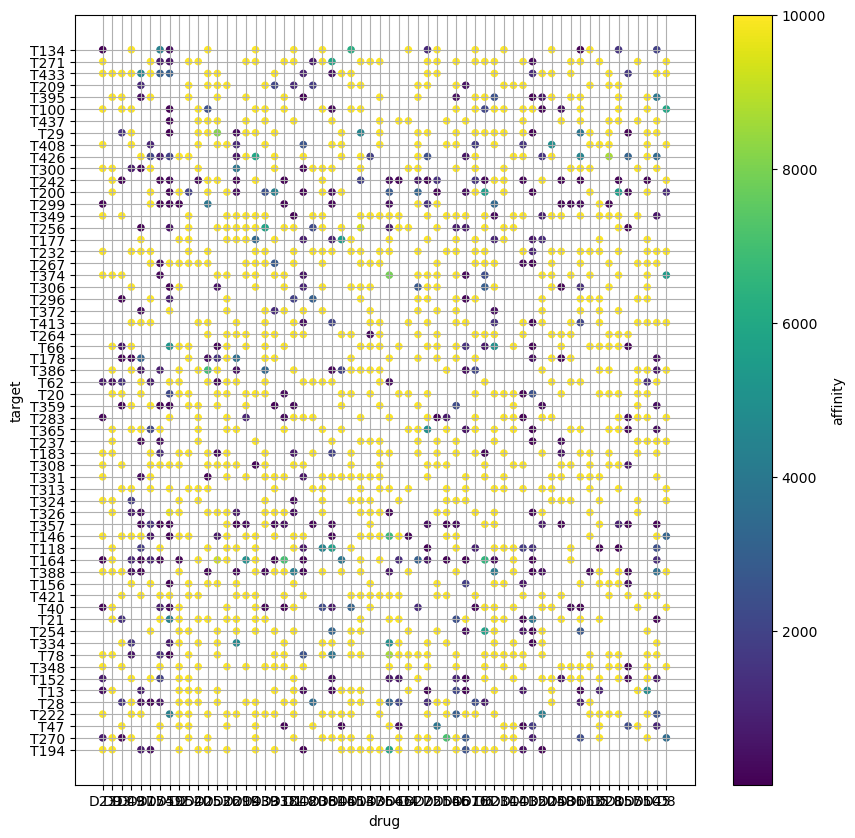

In [3]:
data_df.plot.scatter(x='drug', y='target', c='affinity', colormap='viridis', figsize=(10, 10))
plt.grid(True)

print(f'Number of drugs: {len(data_df["drug"].unique())}')
print(data_df["drug"].unique())
print(f'Number of targets: {len(data_df["target"].unique())}')
print(data_df["target"].unique())

#### Write functions

In [4]:
# Write the functions you need to perform the requested cross-validations.


#### Run cross-validations

In [5]:
# Define K-nearest neighbors regressor with K=20
knn = KNeighborsRegressor(n_neighbors=20)

features_list = features_df.columns.tolist()

In [6]:
# Run the requested cross-validations and print the results.
# Situation 1:  Predict affinities for the remaining pairs of known drugs and targets,Type A, regular loocv

y_pred = []
for test_idx in range(data_df.shape[0]):
    x_test = data_df.loc[test_idx, features_list].values.reshape(1, -1)
    x_train = data_df.loc[data_df.index != test_idx, features_list].values
    y_train = data_df.loc[data_df.index != test_idx, 'affinity'].values 
    knn.fit(x_train, y_train)
    pred = knn.predict(x_test)
    y_pred.append(pred[0])
    
    
    
cindex_1 = concordance_index(data_df["affinity"].values, y_pred)
print(f'Situation 1 - C-index : {cindex_1}')

Situation 1 - C-index : 0.7753800149970941


In [7]:
# Situation 2: Predict affinities of new potential drug molecules to known targets, Type B, remove drug pairs from training set

y_pred = []
for test_idx in range(data_df.shape[0]):
    x_test = data_df.loc[test_idx, features_list].values.reshape(1, -1)
    x_train = data_df.loc[data_df['drug'] != data_df['drug'].loc[test_idx], features_list].values # remove drug pair from training set, include test set
    y_train = data_df.loc[data_df['drug'] != data_df['drug'].loc[test_idx], 'affinity'].values
    #print(x_train.shape)
    knn.fit(x_train, y_train)
    pred = knn.predict(x_test)
    y_pred.append(pred[0])
    


cindex_2 = concordance_index(data_df["affinity"].values, y_pred)
print(f'Situation 2 - C-index : {cindex_2}')


Situation 2 - C-index : 0.7004486294526061


In [8]:
# Situation 3: Predict affinities between new drug molecules and new target molecules, Type D, remove durg and target pairs from training set

y_pred = []
for test_idx in range(data_df.shape[0]):
    x_test = data_df.loc[test_idx, features_list].values.reshape(1, -1)
    x_train = data_df.loc[(data_df['drug'] != data_df['drug'].loc[test_idx]) & (data_df['target'] != data_df['target'].loc[test_idx]), features_list].values # remove drug and target pair from training set, include test set
    y_train = data_df.loc[(data_df['drug'] != data_df['drug'].loc[test_idx]) & (data_df['target'] != data_df['target'].loc[test_idx]), 'affinity'].values
    #print(f'x_train shape: {x_train.shape}')
    knn.fit(x_train, y_train)
    pred = knn.predict(x_test)
    y_pred.append(pred[0])


cindex_3 = concordance_index(data_df["affinity"].values, y_pred)
print(f'Situation 3 - C-index : {cindex_3}')


Situation 3 - C-index : 0.6763313587770585


#### Interpret results

In [9]:
# Interpret the results you obtained and explain why they can be trusted.

The result of stratified leave-one-out cross-validation (SLOOCV) with C-index that I performed for the different pair types (Type A, Type B, and Type D) are 0.7753, 0.7004, 0.6763 respectively. 
- based on the yeild result, it seem that the model performance best on predict affinities for the remaining pairs of known drugs and targets(Type A), and more difficulty distinguishing between dissimilar and new drug-target pairs.
- the reason is because, for the situtions of predict affinities for the remaining pairs of known drugs and targets(Type A), predict affinities of new potential drug molecules to known targets(Type B), leakage more depencencies between training set and test set than predict affinities between new drug molecules and new target molecules sitution(Type D). the model can more easily predict the `affinity` based on given experiences. Just like you are desperately want to know how questions looks like before you enter a exam. 